# Read data from Rigol DS1054Z scope

https://readthedocs.org/projects/ds1054z/downloads/pdf/stable/

### Import the libraries

In [1]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.io as sio
import scipy.signal as sig
from scipy.fft import rfft, rfftfreq
import pyvisa as visa
import time
import os
import shutil

### Define plot mode. 
Interactive mode is helpful for visuallizing the program execution

In [2]:
#%matplotlib widget

### Verify scope connection

In [3]:
scope = DS1054Z('192.168.1.206')

In [4]:
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


### Test Description

This sheet is designed to take data on a Rigol DS1054z oscilloscope with channel 1 of the scope connected to an MSP6729 magnetic pick up viewing the chuck of a 7" x 10" mini lathe. 

Channel 1 common of the oscilloscope is connected to the magnetic pick up shield wire and the black wire. The signal of channel 1 is connected to the red wire of the mag pick up.

![alt text](IMG_8440_Scope2MagPickup_Labels.png "Oscilloscope Connections")

### Define functions used in the test

#### This is the function that sets the trigger level


In [5]:
def b_set_trigger(d_trigger_level = 1e-01):
    """Set the trigger configuration
    
    Keyword arguments:
    d_trigger_level -- Voltage level to trigger scope (default: 0.1 volts)
    
    Return values:
    [None]
    """
    
    scope.write(':trigger:edge:source CHAN1')
    scope.write(':trigger:edge:level ' + format(d_trigger_level))
    scope.single() 

#### Function that contains the commands that setup the scope

In [6]:
def b_setup_scope(scope, d_ch1_scale=5.e-1, timebase_scale=5e-2, 
                  d_trigger_level = 1e-01, b_single = True):
    """Setup Rigol ds1054z to read a 3/8-24 magnetic pickup
    
    Keyword arguments:
    scope -- Connection to scope
    d_ch1_scale  -- Channel 1 scale (default: 0.5 volts)
    timebase_scale -- Time scale for data (default: 0.005 seconds)
    d_trigger_level -- Voltage level to trigger scope (default: 0.1 volts)
    b_trigger -- If true, then use trigger levels (default: True)
    
    Return values:
    d_ch1_scale_actual -- The closest value chosen by the scope
    """
    
    scope.timebase_scale = timebase_scale
    scope.run()
    scope.display_channel(1,enable=True)
    scope.set_probe_ratio(1,1)
    scope.set_channel_scale(1,"{:e}".format(d_ch1_scale) +'V')
    scope.write(':CHANnel1:COUPling AC')

    scope.display_channel(2,enable=False)
    scope.display_channel(3,enable=False)
    scope.display_channel(4,enable=False)
    
    # Do we need a trigger?
    if b_single:
        
        # Set the scope to capture after trigger
        b_set_trigger(d_trigger_level)
        
    else:
        
        # No trigger, useful for seeing the scope data when you aren't sure
        # what the signal looks like
        scope.write(":TRIGger:SWEep AUTO")
        
    return scope.get_channel_scale(1)

#### Verify the help comments are at least somewhat on point

In [7]:
help(b_setup_scope)

Help on function b_setup_scope in module __main__:

b_setup_scope(scope, d_ch1_scale=0.5, timebase_scale=0.05, d_trigger_level=0.1, b_single=True)
    Setup Rigol ds1054z to read a 3/8-24 magnetic pickup
    
    Keyword arguments:
    scope -- Connection to scope
    d_ch1_scale  -- Channel 1 scale (default: 0.5 volts)
    timebase_scale -- Time scale for data (default: 0.005 seconds)
    d_trigger_level -- Voltage level to trigger scope (default: 0.1 volts)
    b_trigger -- If true, then use trigger levels (default: True)
    
    Return values:
    d_ch1_scale_actual -- The closest value chosen by the scope



#### Define the function that acquires data from scope
This one is a little tricky because it can take time to acquire the signal so there are pause statements to allow data to accumulate at the scope. If the acquisition terminates before the sampling is complete there will be NaN's in the list. In this case the NaN's are converte zeros to allow processing to continue. It can be helpful to see a partial waveform to troubleshoot timing at the scope.

In [8]:
def d_get_data(i_ch=1, timebase_scale=5e-2):
    """Get data from the scope
    
    Keyword arguments:
    i_ch -- 1-based index of channel to sample (default: 1)
    
    Return values:
    np_d_ch1 -- numpy array of values from the scope
    """
    
    # Calculate the delay time
    d_time_delay = timebase_scale*32 + 1.
    
    # Acquire the data
    time.sleep(d_time_delay)
    d_ch1 = scope.get_waveform_samples(i_ch, mode='NORM')
    time.sleep(d_time_delay)
    scope.run()
    
    # Convert the list to a numpy array and replace NaN's with zeros
    np_d_ch1 = np.array(d_ch1) 
    np_d_ch1 = np.nan_to_num(np_d_ch1)
    
    return np.array(np_d_ch1)

#### Verify the help text

In [9]:
help(d_get_data)

Help on function d_get_data in module __main__:

d_get_data(i_ch=1, timebase_scale=0.05)
    Get data from the scope
    
    Keyword arguments:
    i_ch -- 1-based index of channel to sample (default: 1)
    
    Return values:
    np_d_ch1 -- numpy array of values from the scope



#### Define the function that extracts features from the data

In [10]:
class cl_sig_features:
    
    """Class to manage signal features on scope data
    
    Example usage:
        cl_test = cl_sig_features(np.array([1.,2., 3.]),1.1) 
        
    Should produce:
    
        print('np_d_ch1: '+ np.array2string(cl_test.np_d_ch1))
        print('timebase_scale: ' + '%0.3f' % cl_test.timebase_scale)
        print('i_ns: ' + '%3.f' % cl_test.i_ns)
        print('d_t_del: ' + '%0.3f' % cl_test.d_t_del)
        print('d_time' + np.array2string(cl_test.d_time))
        
        np_d_ch1: [1. 2. 3.]
        timebase_scale: 1.000
        i_ns:   3
        d_t_del: 4.000
        d_time[0. 4. 8.]
        
    """

    def __init__(self, np_d_ch1, timebase_scale):
        self.__np_d_ch1 = np_d_ch1
        self.__timebase_scale = float(timebase_scale)
        self.__np_d_rpm = np.zeros_like(self.np_d_ch1)
        self.__d_thresh = np.NaN
        self.__d_events_per_rev = np.NaN
        
    @property
    def np_d_ch1(self):
        """Numpy array containing the scope data"""
        return self.__np_d_ch1
    
    @property
    def timebase_scale(self):
        """Scope time scale"""
        return self.__timebase_scale
    
    @property
    def i_ns(self):
        """Number of samples in the scope data"""
        self.__i_ns = len(self.__np_d_ch1)
        return self.__i_ns
    
    @property
    def d_t_del(self):
        """Delta time between each sample"""
        self.__d_t_del = (12.*float(self.timebase_scale))/float(self.i_ns)
        return self.__d_t_del

    @property
    def d_time(self):
        """Numpy array with time values, in seconds"""
        self.__d_time = np.linspace(0,(self.i_ns-1),self.i_ns)*self.d_t_del
        return self.__d_time
    
    @property 
    def d_fs(self):
        """Sampling frequeny in hertz"""
        self.__d_fs = 1.0/(self.__d_time[1]-self.__d_time[0])
        return self.__d_fs
    
    @property
    def np_d_ch1_filt(self):
        """ Return the signal, filtered with Savitsky-Golay"""
        self.__i_win_len = 31;
        self.__i_poly_order = 1;
        self.__np_d_ch1_filt = sig.savgol_filter(self.np_d_ch1, 
                                                 self.__i_win_len, 
                                                 self.__i_poly_order);
        self.__str_filt_desc = ('Savitsky-Golay | Window Length: ' + 
                                 '%3.f' % self.__i_win_len + 
                                ' | Polynomial Order: ' + '%2.f' % self.__i_poly_order) 
        self.__str_filt_desc_short = 'SGolay'
        return self.__np_d_ch1_filt

    @property
    def str_filt_desc(self):
        "Complete Filt description of the Savitsky-Golay filter design"
        return self.__str_filt_desc

    @property
    def str_filt_desc_short(self):
        """Short Filt description, useful for plot legend labels"""
        return self.__str_filt_desc_short

    @property
    def np_d_ch1_filt1(self):
        """ Return the signal, filtered with butter FIR filter"""
        self.__i_poles = 1
        if self.d_fs < 300:
            self.__d_wn = fs/8
        else:
            self.__d_wn = 100
            
        self.__sos = sig.butter(self.__i_poles, self.__d_wn, btype='low', 
                                fs=self.d_fs, output = 'sos')
        self.__np_d_ch1_filt1 = sig.sosfilt(self.__sos, self.np_d_ch1)
        self.__str_filt1_desc = ('Butterworth | Poles: ' + 
                                 '%2.f' % self.__i_poles + 
                                ' | Lowpass corner (Hz): ' + '%0.2f' % self.__d_wn) 
        self.__str_filt1_desc_short = 'Butter'
        return self.__np_d_ch1_filt1
    
    @property
    def str_filt1_desc(self):
        "Complete Filt1 description of the Butterworth filter design"
        return self.__str_filt1_desc

    @property
    def str_filt1_desc_short(self):
        """Short Filt1 description, useful for plot legend labels"""
        return self.__str_filt1_desc_short
    
    @property
    def np_d_eventtimes(self):
        """Numpy array of trigger event times"""
        return self.__np_d_eventtimes
    
    @property
    def d_thresh(self):
        """Trigger threshold value"""
        return self.__d_thresh
    
    @property
    def np_d_rpm(self):
        """Estimated RPM values"""
        return self.__np_d_rpm
    
    @property
    def d_events_per_rev(self):
        """Events per revolution"""
        return self.__d_events_per_rev
    
    @np_d_ch1.setter
    def np_d_ch1(self, np_d_ch1):
        self.__np_d_ch1 = np_d_ch1

    @timebase_scale.setter
    def timebase_scale(self, timebase_scale):
        self.__timebase_scale = timebase_scale


    # Method for calculating the spectrum for a real signal
    def d_fft_real(self):
        """Calculate the half spectrum since this is a real-valued signal"""
        d_y = rfft(np_d_ch1)
        d_ws = rfftfreq(self.i_ns, 1./self.d_fs)
        return([d_ws, d_y])
    

    # Plotting method, time domain signals.
    def plt_sigs(self):
        """Plot out the data in this signal feature class in the time domain
        
        Return values:
        handle to the plot
        """
        plt.figure()
        plt.plot(self.d_time, self.np_d_ch1)
        plt.plot(self.d_time, self.np_d_ch1_filt)
        plt.plot(self.d_time, self.np_d_ch1_filt1)
        plt.grid()
        plt.xlabel("Time, seconds")
        plt.ylabel("Channel output, volts")
        plt.legend(['as-aquired', self.str_filt_desc_short, 
            self.str_filt1_desc_short])
        plt.show()
        self.__plot_handle = plt.gcf()
        return self.__plot_handle    
    
    # Plotting method for single-sided (real signal) spectrum
    def plt_spec(self):
        """Plot data in frequency domain. This method assumes a real signal
        
        Return values:
        handle to the plot
        """
        self.__spec = self.d_fft_real()
        plt.figure()
        plt.plot(self.__spec[0], np.abs(self.__spec[1]))
        plt.grid()
        plt.xlabel("Frequency, hertz")
        plt.ylabel("Channel amplitude, volts")
        plt.show()
        self.__plot_handle = plt.gcf()
        return [self.__plot_handle, self.__spec[0], self.__spec[1]]    
    
    # Plotting method for the eventtimes
    def plt_eventtimes(self):
        """Plot event data in time. 
        
        Return values:
        list: [handle to the plot, np array of eventtimes]
        """
        
        # The eventtimes all should have threshold value for voltage
        self.__np_d_eventvalue = np.ones_like(self.__np_d_eventtimes)*self.d_thresh
        
        # Put up the the plot time
        plt.figure()
        plt.plot(self.__d_time, self.np_d_ch1)
        plt.plot(self.np_d_eventtimes, self.__np_d_eventvalue, "ok")
        plt.xlabel('Time, seconds')
        plt.ylabel('Amplitude, volts')
        plt.legend(['as-aquired', 'eventtimes'])
        plt.title('Amplitude and eventtimes vs. time')
        self.__plot_handle = plt.gcf()
        return [self.__plot_handle, self.__np_d_eventtimes]    
    
    # Plotting method for the eventtimes
    def plt_rpm(self):
        """Plot rpm data in time. 
        
        Return values:
        list: [handle to the plot, np array of RPM values]
        """
        
        # Put up the the plot time
        fig,ax1 = plt.subplots()
        
        ax2 = ax1.twinx()
        
        ax1.plot(self.__d_time, self.np_d_ch1)
        ax2.plot(self.np_d_eventtimes, self.__np_d_rpm, "ok")
        ax1.set_xlabel('Time, seconds')
        ax1.set_ylabel('Amplitude, volts')
        ax2.set_ylabel('Event speed, RPM')
        plt.legend(['as-aquired', 'RPM'])
        plt.title('Amplitude and eventtimes vs. time')
        plt.show()        
        
        self.__plot_handle = plt.gcf()
        return [self.__plot_handle, self.__np_d_rpm]    
    
    # Estimate triggers for speed,  public method
    def np_d_est_triggers(self, i_direction=0, d_thresh=0, d_hyst=0.1, i_kernel=5, b_verbose=False):
        """
        This method estimates speed by identifying trigger points in time, 
        a given threshold and hysteresis. When the signal level crosses the threshold,
        the trigger holds off. The trigger holds off until the signal crosses
        hysteresis levels. Hysteresis is defined relative to the threshold voltage. 
        
        The trigger times can be used to estimate the rotating speed.
        
        Keyword arguments:
        i_direction -- 0 to search for threshold on rising signal, 1 to search
                        on a falling signal.
        d_thresh  -- Threshold value (default: 0.0 volts for zero crossings)
        d_hyst -- Hysteresis value (default: 0.1 volts)
        i_kernel -- Number of samples to consider in estimating slope, 
                        must be an odd number (default: 5)
        b_verbose -- Print the intermediate steps (default: False). Useful
                        for stepping through the method to troubleshoot or
                        understand it better.

        Return values:
        np_d_eventtimes -- numpy array with list of trigger event times
        """
        
        # Store to local private member, it gets used in other places in the class
        self.__d_thresh = d_thresh
        
        # Initialize trigger state to hold off: the trigger will be active
        # once the signal crosses the hysteresis
        b_trigger_hold = True
        
        # half kernel get used a lot
        self.__i_half_kernel = int((i_kernel - 1)/2.)
        
        # Use smoothing and derivative functions of S-G filter for estimating rise/fall
        self.__np_d_ch1_dir = sig.savgol_filter(self.np_d_ch1, 
                                         i_kernel, 1, deriv=1);

        
        # Initiate state machine: one state for rising signal, 'up', (i_direction = 0) 
        # and another for falling signal, 'down', (i_direction = 1)
        self.__d_hyst_abs = 0
        idx_event = 0
        self.__np_d_eventtimes = np.zeros_like(self.np_d_ch1)
        if i_direction == 0:
            
            # Define the absolute hysteretic value, rising
            self.__d_hyst_ab = self.__d_thresh - d_hyst
            
            # Loop through the signal
            for idx,x in enumerate(self.np_d_ch1):
                
                # Intermediate results
                if b_verbose:
                    print('idx: ' + '%2.f' % idx + ' | x: ' + '%0.5f' % x +
                          ' | s-g: ' + '%0.4f' % self.__np_d_ch1_dir[idx])
                
                # The trigger leaves 'hold-off' state if the slope is
                # negative and we fall below the threshold
                if (x <= self.__d_hyst_ab and self.__np_d_ch1_dir[idx] < 0 and
                   b_trigger_hold == True):
                    
                    # Next time the signal rises above the threshold, trigger
                    # will be set to hold-off state
                    b_trigger_hold = False
                    
                # If we are on the rising portion of the signal and there is no hold off
                # state on the trigger, trigger, and change state
                if (x >= self.__d_thresh and self.__np_d_ch1_dir[idx] > 0 and
                   b_trigger_hold == False):
                    
                    # Change state to hold off
                    b_trigger_hold = True
                    
                    # Estimate time of crossing with interpolation
                    if idx>0:
                        
                        # Interpolate to estimate the actual crossing from the 2 nearest points
                        xp = np.array([self.np_d_ch1[idx-1], self.np_d_ch1[idx]])
                        fp = np.array([self.__d_time[idx-1], self.__d_time[idx]])
                        self.__np_d_eventtimes[idx_event] = np.interp(d_thresh, xp, fp)
                        
                        # More intermediate results
                        if b_verbose:
                            print('xp: ' + np.array2string(xp) + ' | fp: ' + np.array2string(fp) +
                                 ' | d_thresh: ' + '%0.4f' % d_thresh + ' | eventtimes: ' + 
                                 '%0.4f' % self.__np_d_eventtimes[idx_event])
                            
                        # Increment the eventtimes index
                        idx_event += 1
                
        else:
        
            # Define the absolute hysteretic value, falling
            self.__d_hyst_ab = self.__d_thresh + d_hyst
            
            # Loop through the signal
            for idx,x in enumerate(self.np_d_ch1):
                
                # Intermediate results
                if b_verbose:
                    print('idx: ' + '%2.f' % idx + ' | x: ' + '%0.5f' % x +
                          ' | s-g: ' + '%0.4f' % self.__np_d_ch1_dir[idx])
                
                # The trigger leaves 'hold-off' state if the slope is
                # positive and we rise above the threshold
                if (x >= self.__d_hyst_ab and self.__np_d_ch1_dir[idx] > 0 and
                   b_trigger_hold == True):
                    
                    # Next time the signal rises above the threshold, trigger
                    # will be set to hold-off state
                    b_trigger_hold = False
                    
                # If we are on the falling portion of the signal and there is no hold off
                # state on the trigger, trigger, and change state
                if (x <= self.__d_thresh and self.__np_d_ch1_dir[idx] < 0 and
                   b_trigger_hold == False):
                    
                    # Change state to hold off
                    b_trigger_hold = True
                    
                    # Estimate time of crossing with interpolation
                    if idx>0:
                        
                        # Interpolate to estimate the actual crossing from the 2 nearest points
                        xp = np.array([self.np_d_ch1[idx-1], self.np_d_ch1[idx]])
                        fp = np.array([self.__d_time[idx-1], self.__d_time[idx]])
                        self.__np_d_eventtimes[idx_event] = np.interp(d_thresh, xp, fp)
                        
                        # More intermediate results
                        if b_verbose:
                            print('xp: ' + np.array2string(xp) + ' | fp: ' + np.array2string(fp) +
                                 ' | d_thresh: ' + '%0.4f' % d_thresh + ' | eventtimes: ' + 
                                 '%0.4f' % self.__np_d_eventtimes[idx_event])
                            
                        # Increment the eventtimes index
                        idx_event += 1
        
        # Remove zero-valued element
        self.__np_d_eventtimes = np.delete(self.__np_d_eventtimes, np.where(self.__np_d_eventtimes == 0))
        
        return self.__np_d_eventtimes
    
    # Method to estimate the RPM values
    def d_est_rpm(self, d_events_per_rev=1):
        """
        Estimate the RPM from the signal using eventtimes which must have calculate
        with a previous call to the method np_d_est_triggers.
        """
        
        # Store the new value in the object
        self.__d_events_per_rev = d_events_per_rev
        
        # Calculate the RPM using the difference in event times
        self.__np_d_rpm = 60./(np.diff(self.np_d_eventtimes)*float(d_events_per_rev))
        
        # To keep the lengths the same, append the last sample
        self.__np_d_rpm = np.append(self.__np_d_rpm, self.__np_d_rpm[len(self.__np_d_rpm)-1])
        
        return self.__np_d_rpm
    
    # Save the data
    def b_save_data(self, str_data_prefix = 'testclass', idx_data=1):
        """
        Save the data in the object to a .csv file
        
        Keyword arguments:
        str_data_prefix -- String with file prefix (defaults to 'testclass')
        idx_data -- File index (defaults to 1)
        
        Return values:
        True if write succeeds
        
        """
        str_file = str_data_prefix + '_' '%03.0f' % idx_data + '.csv'
        file_data = open(str_file,'w+')
        file_data.write('X,CH1,Start,Increment,\n')
        str_line = 'Sequence,Volt,Volt,0.000000e-03,' + str(self.d_t_del)
        file_data.write(str_line+'\n')

        for idx_line in range(0, self.i_ns):
            str_line = str(idx_line) + ',' + '%0.5f' % self.np_d_ch1[idx_line] + ',' + ','
            file_data.write(str_line+'\n')

        file_data.close()
        
        return True

#### Verify help and class structure

In [11]:
help(cl_sig_features)

Help on class cl_sig_features in module __main__:

class cl_sig_features(builtins.object)
 |  cl_sig_features(np_d_ch1, timebase_scale)
 |  
 |  Class to manage signal features on scope data
 |  
 |  Example usage:
 |      cl_test = cl_sig_features(np.array([1.,2., 3.]),1.1) 
 |      
 |  Should produce:
 |  
 |      print('np_d_ch1: '+ np.array2string(cl_test.np_d_ch1))
 |      print('timebase_scale: ' + '%0.3f' % cl_test.timebase_scale)
 |      print('i_ns: ' + '%3.f' % cl_test.i_ns)
 |      print('d_t_del: ' + '%0.3f' % cl_test.d_t_del)
 |      print('d_time' + np.array2string(cl_test.d_time))
 |      
 |      np_d_ch1: [1. 2. 3.]
 |      timebase_scale: 1.000
 |      i_ns:   3
 |      d_t_del: 4.000
 |      d_time[0. 4. 8.]
 |  
 |  Methods defined here:
 |  
 |  __init__(self, np_d_ch1, timebase_scale)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  b_save_data(self, str_data_prefix='testclass', idx_data=1)
 |      Save the data in the object to a .

### Setup the test sequence

Seed the sequence, these typically work well for 200-500 RPM and the mag pick-up gapped at 10 mils

In [12]:
str_data_prefix = 'test010'
idx_data = 0
d_timebase_scale = 1e-1
d_ch1_scale = 5.e-1

### Acquisition loop
This loop has several steps:

#### Acquire discovery signal
The code does not assume an RPM so it derives it from signal features.

#### Scope setup
Setup the vertical and horizontal scales on the scope. For the first pass, no trigger is used and time scale is set so that at least 2 revolutions of the lathe should be seen in the signal. This lets us see if the signal is valid and how we want to configure the trigger.

#### Initial acquisition
Once the setup is complete acquire the data and push the information into the signal feature class. The speed will be used to set the timescale so that we get about 5 events in the scope window

#### Visualize the data
A few plots are presented of the scope data. Useful for troubleshooting

#### Estimate the speed
With the event frequency known, the scope timebase_scale can be calculated

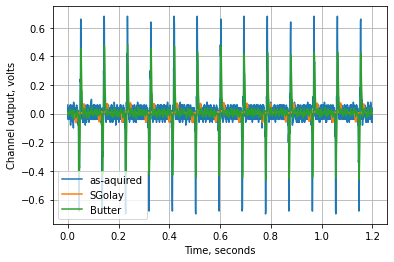

d_timebase_scale (prior to adjustment): 0.100
d_timebase_scale (after adjustment): 0.046
d_pkpk: 1.3800
d_volts_scale: 4.0000
Voltage scale increased


<Figure size 432x288 with 0 Axes>

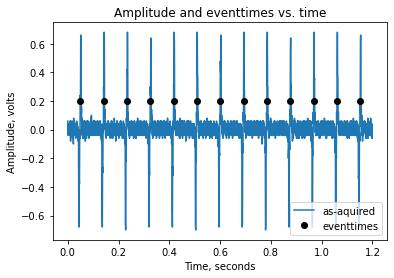

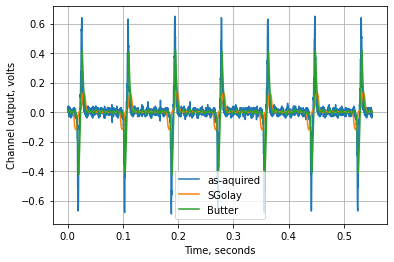

Press Enter to continue...


<Figure size 432x288 with 0 Axes>

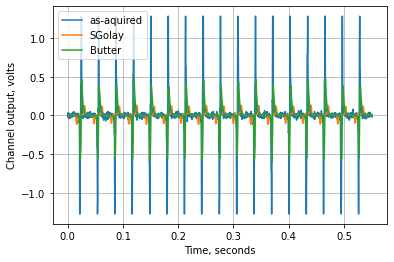

d_timebase_scale (prior to adjustment): 0.046
d_timebase_scale (after adjustment): 0.016
d_pkpk: 2.5500
d_volts_scale: 2.0000
Voltage scale reduced


<Figure size 432x288 with 0 Axes>

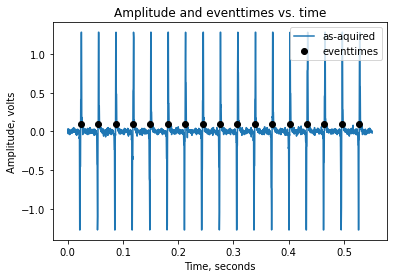

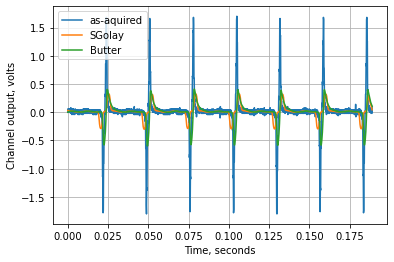

Press Enter to continue...


<Figure size 432x288 with 0 Axes>

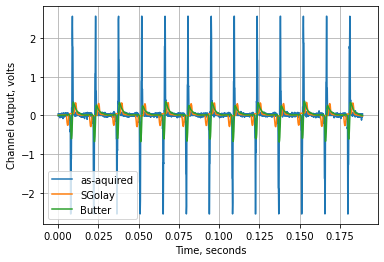

d_timebase_scale (prior to adjustment): 0.016
d_timebase_scale (after adjustment): 0.007
d_pkpk: 5.1000
d_volts_scale: 4.0000
Voltage scale reduced


<Figure size 432x288 with 0 Axes>

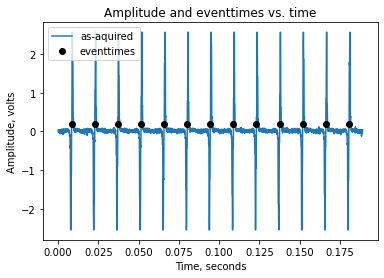

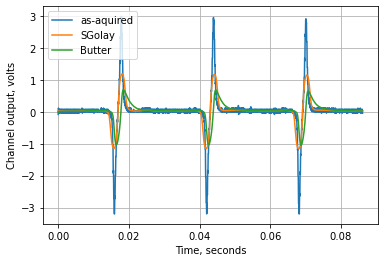

Press Enter to continue...


<Figure size 432x288 with 0 Axes>

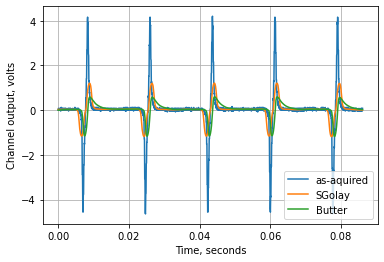

d_timebase_scale (prior to adjustment): 0.007
d_timebase_scale (after adjustment): 0.009
d_pkpk: 8.8400
d_volts_scale: 8.0000
Voltage scale reduced


<Figure size 432x288 with 0 Axes>

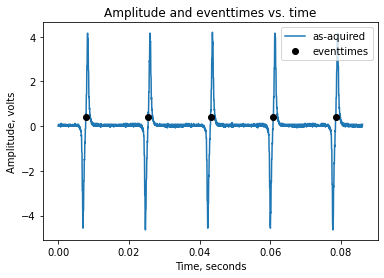

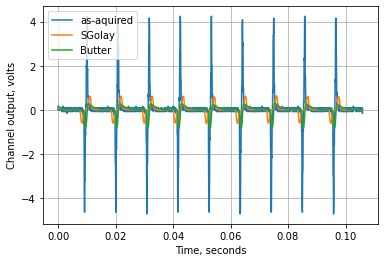

Press Enter to continue...


<Figure size 432x288 with 0 Axes>

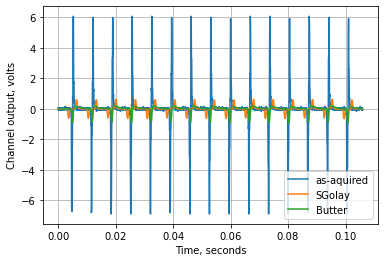

d_timebase_scale (prior to adjustment): 0.009
d_timebase_scale (after adjustment): 0.003
d_pkpk: 12.9600
d_volts_scale: 16.0000


<Figure size 432x288 with 0 Axes>

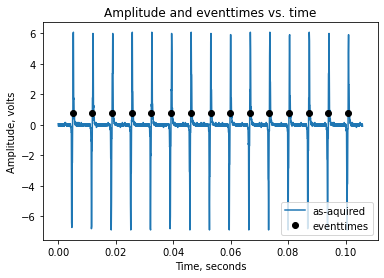

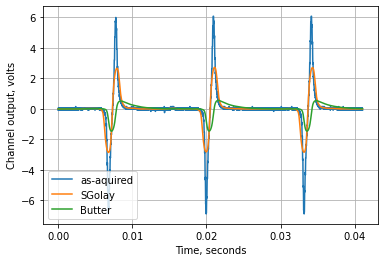

Press Enter to continue...


<Figure size 432x288 with 0 Axes>

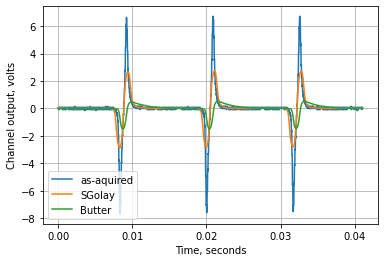

d_timebase_scale (prior to adjustment): 0.003
d_timebase_scale (after adjustment): 0.006
d_pkpk: 14.4000
d_volts_scale: 16.0000


<Figure size 432x288 with 0 Axes>

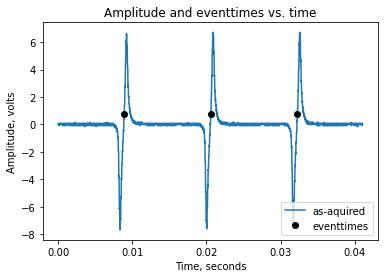

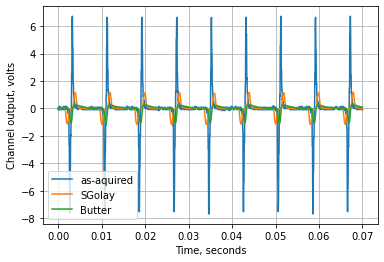

KeyboardInterrupt: Interrupted by user

<Figure size 432x288 with 0 Axes>

In [13]:
while True:
    
    # Setup the scope for the trial sample acquisition
    d_ch1_scale = b_setup_scope(scope, d_ch1_scale=d_ch1_scale, timebase_scale=d_timebase_scale, 
              d_trigger_level = 1e-01, b_single = False)
    
    # Acquire the test sample
    np_d_ch1 = d_get_data(i_ch=1, timebase_scale=d_timebase_scale)
    
    # Instatiate the class, send the waveform samples and scales
    cl_sig_no_trigger = cl_sig_features(np_d_ch1, d_timebase_scale)
    
    # Plot out the signal
    hp = cl_sig_no_trigger.plt_sigs()
    
    # The shape of the response is similar as speed increased, but the
    # triggering threshold has to increase to accomodate the higher
    # amplitudes
    d_thresh_est = 0.2 * (d_ch1_scale/0.5)
    
    # Calculate the trigger event times
    np_d_eventtimes = cl_sig_no_trigger.np_d_est_triggers(i_direction=0, 
                                                          d_thresh=d_thresh_est, d_hyst=0.2, b_verbose=False)
    np_d_eventtimes
    
    # Visualize the eventtimes
    hp = cl_sig_no_trigger.plt_eventtimes()
    
    # Calculated the desired timebase_scale
    print("d_timebase_scale (prior to adjustment): " '%0.3f' % d_timebase_scale)
    d_timebase_scale = (6./12.)*(np.mean(np.diff(np_d_eventtimes)))
    print("d_timebase_scale (after adjustment): " '%0.3f' % d_timebase_scale)
    
    # Check for clipping and correct scaling. The scope has 8 vertical division so the 
    # total voltage range on the screen is 8 * d_ch1_scale 
    d_pkpk = np.max(np_d_ch1) - np.min(np_d_ch1)
    print("d_pkpk: " + "%0.4f" % d_pkpk)
    d_volts_scale = (8*d_ch1_scale)
    print("d_volts_scale: " + "%0.4f" % d_volts_scale)
    if ( d_pkpk > d_volts_scale ):
        print("Voltage scale reduced")
        d_ch1_scale = d_ch1_scale*2.
    
    # Could be the vertical scale is too small, check for that
    if ( abs( d_volts_scale/d_pkpk > 2. )):
        print("Voltage scale increased")
        d_ch1_scale = d_ch1_scale/2.
    
    # The scope trigger setting scales with the overall amplitude since the
    # shape of the response is similar
    d_trigger_level_est = 0.2 * (d_ch1_scale/0.5)
    
    # Reset the scope with the adjusted features, set to trigger on single sample
    b_setup_scope(scope, d_ch1_scale=d_ch1_scale, timebase_scale=d_timebase_scale, 
              d_trigger_level = 1e-01, b_single = True)
    
    # Acquire the sample
    np_d_ch1 = d_get_data(i_ch=1, timebase_scale=d_timebase_scale)
    
    # Reset back to free-run
    b_setup_scope(scope, d_ch1_scale=d_ch1_scale, timebase_scale=d_timebase_scale, 
              d_trigger_level = 1e-01, b_single = False)

    # Instatiate the class, send the waveform samples and scales
    cl_sig_no_trigger = cl_sig_features(np_d_ch1, d_timebase_scale)

    # Visualize the data
    hp = cl_sig_no_trigger.plt_sigs()
        
    # Save it off to a file    
    b_file_save = cl_sig_no_trigger.b_save_data(str_data_prefix = str_data_prefix, idx_data = idx_data)
        
    # Wait for the next speed adjustment and continue
    idx_data += 1
    time.sleep(2)
    input("Press Enter to continue...")